### Libaries

arch library is available
statsmodels.tsa.arch is not available
Library Versions:
statsmodels: 0.14.5
pandas: 2.3.1
numpy: 2.0.2
scikit-learn: 1.6.1
----------------------------------------
Starting comprehensive analysis...


[*********************100%***********************]  3 of 3 completed


Stock data shape: (2515, 3)
Factor data shape: (2516, 4)
Merging stock and factor data...
Merged data shape: (2515, 10)

=== Analyzing AAPL ===
Running OLS regression for AAPL...
Running RIDGE regression for AAPL...
Running LASSO regression for AAPL...
Trying GARCH models with different implementations...
Running GARCH model using auto method...
Running EWMA volatility model (λ = 0.94)...

=== Analyzing MSFT ===
Running OLS regression for MSFT...
Running RIDGE regression for MSFT...
Running LASSO regression for MSFT...
Trying GARCH models with different implementations...
Running GARCH model using auto method...
Running EWMA volatility model (λ = 0.94)...

=== Analyzing GOOGL ===
Running OLS regression for GOOGL...
Running RIDGE regression for GOOGL...
Running LASSO regression for GOOGL...
Trying GARCH models with different implementations...
Running GARCH model using auto method...
Running EWMA volatility model (λ = 0.94)...

FACTOR MODEL ANALYSIS COMPLETE

📋 SUMMARY TABLE:
Ticker OLS

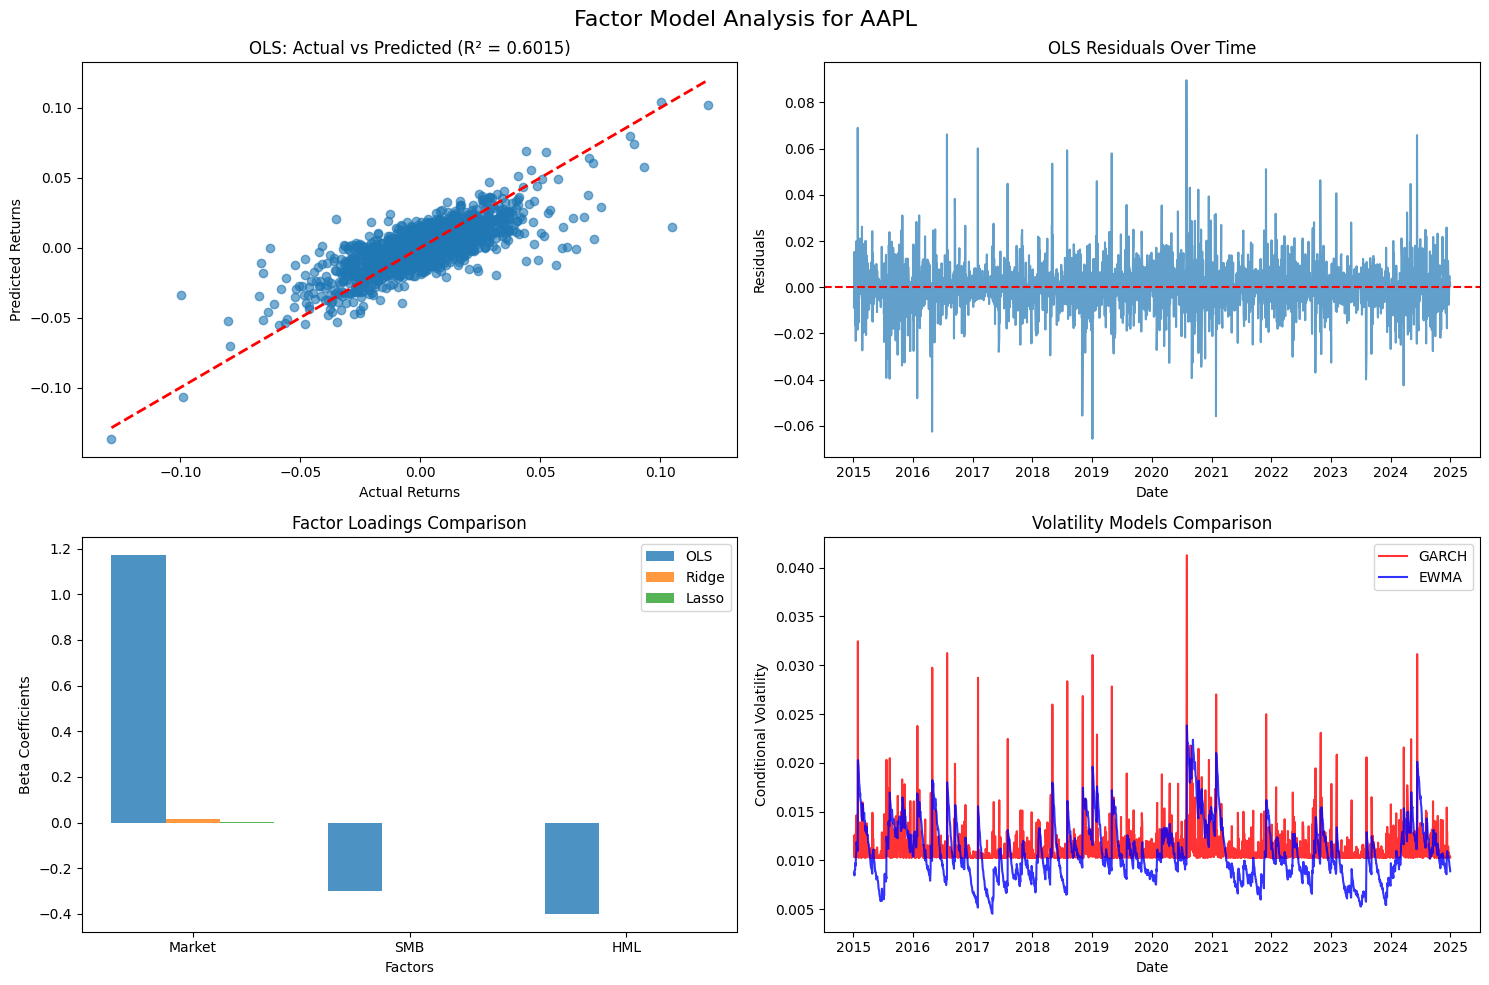


DETAILED RESULTS FOR MSFT

📊 OLS REGRESSION RESULTS:
Alpha (Jensen's Alpha): 0.000363
Beta Market: 1.2031
Beta SMB: -0.4396
Beta HML: -0.4634
R-squared: 0.7113
Adjusted R-squared: 0.7110

📈 INTERPRETATION:
• Market sensitivity: High
• Size factor: Large-cap tilt
• Value factor: Growth tilt
• Model explains 71.1% of return variance

🤖 MACHINE LEARNING RESULTS:
Ridge R²: 0.7113
Lasso R²: 0.2806
Best ML Model: Ridge

📊 GARCH MODEL RESULTS (arch_library):
Average conditional volatility: 0.0091
Volatility range: 0.0078 - 0.0143

📊 EWMA VOLATILITY MODEL:
Average volatility: 0.0087
Lambda parameter: 0.9400


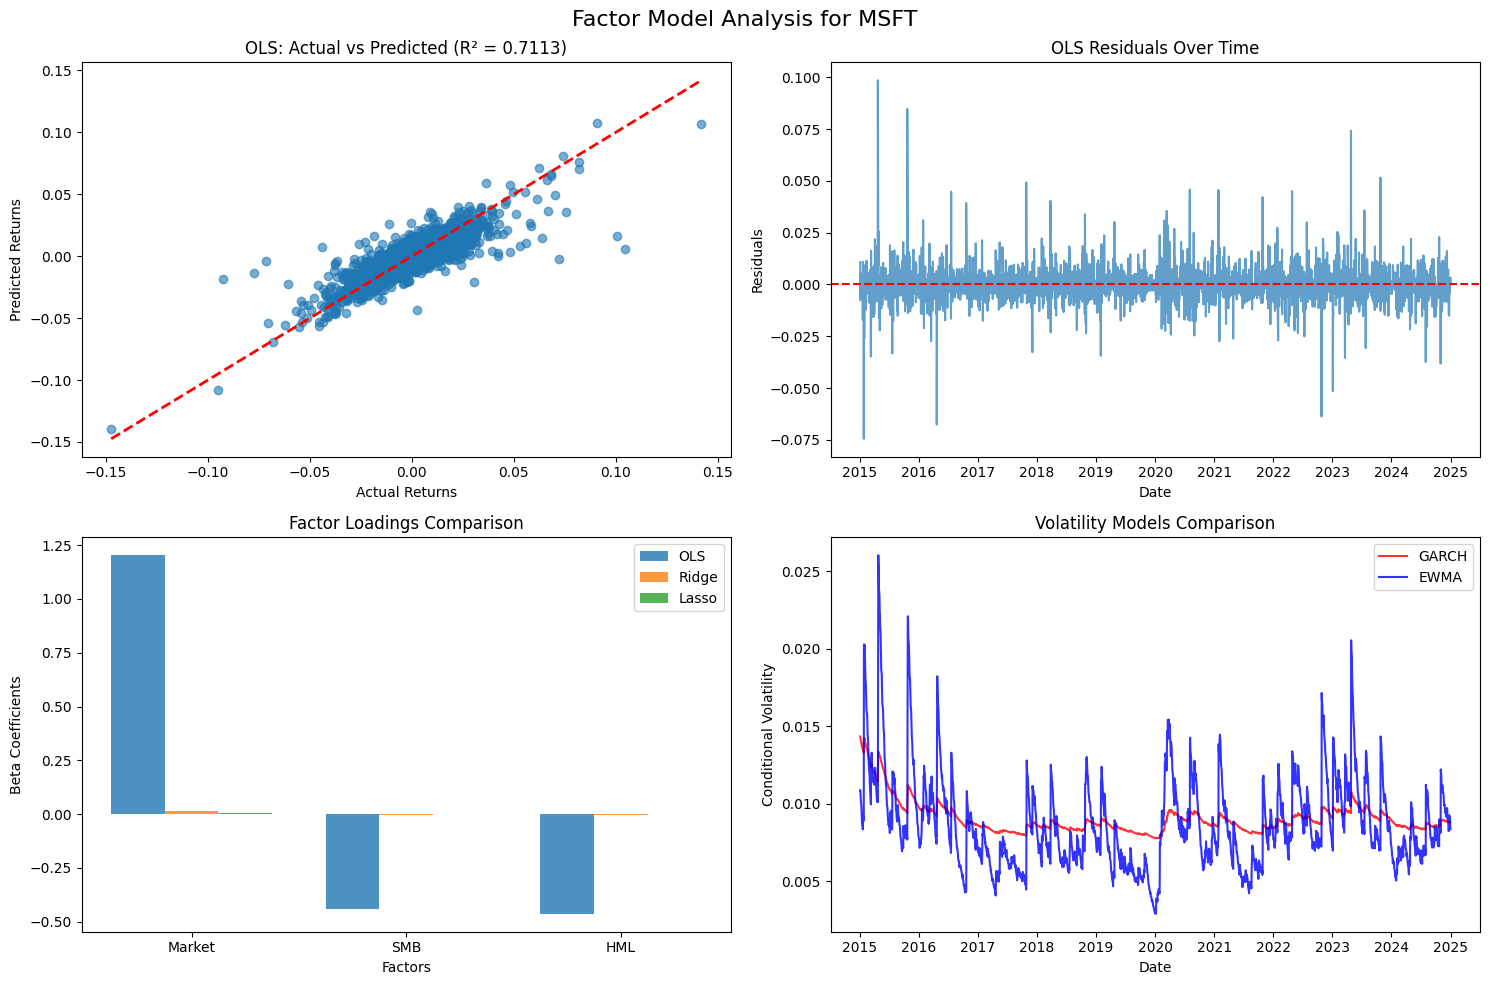


DETAILED RESULTS FOR GOOGL

📊 OLS REGRESSION RESULTS:
Alpha (Jensen's Alpha): 0.000279
Beta Market: 1.1248
Beta SMB: -0.2588
Beta HML: -0.4146
R-squared: 0.5634
Adjusted R-squared: 0.5629

📈 INTERPRETATION:
• Market sensitivity: High
• Size factor: Large-cap tilt
• Value factor: Growth tilt
• Model explains 56.3% of return variance

🤖 MACHINE LEARNING RESULTS:
Ridge R²: 0.5634
Lasso R²: 0.1996
Best ML Model: Ridge

📊 GARCH MODEL RESULTS (arch_library):
Average conditional volatility: 0.0119
Volatility range: 0.0093 - 0.1002

📊 EWMA VOLATILITY MODEL:
Average volatility: 0.0110
Lambda parameter: 0.9400


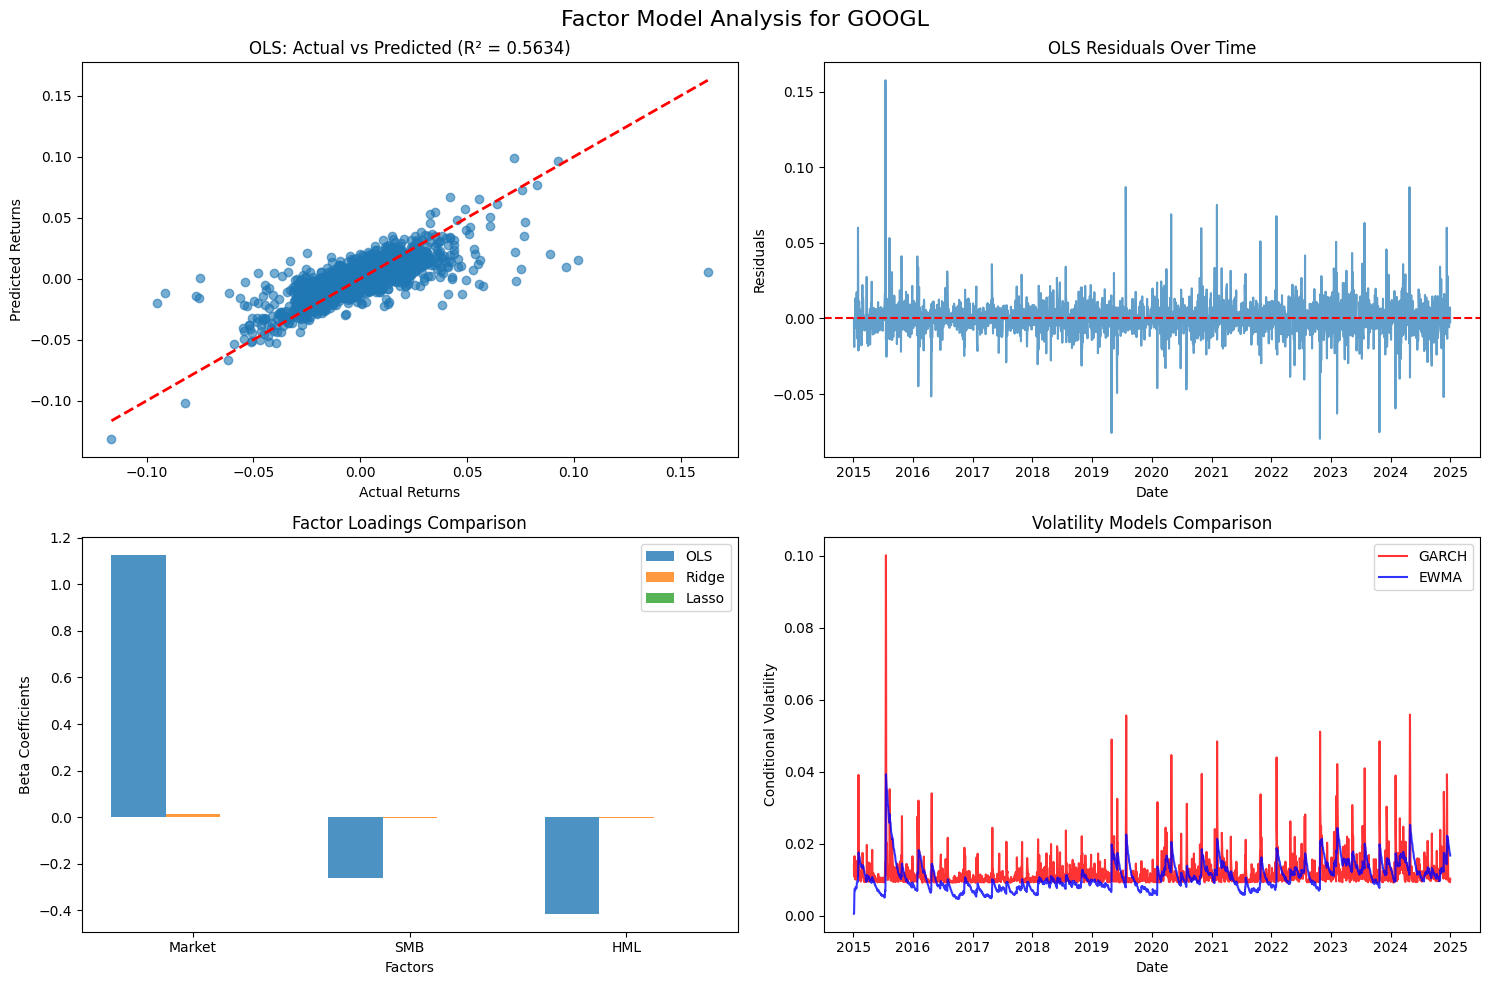


📊 Generating plots for AAPL...

✅ Analysis complete! Check the plots and detailed results above.

💡 Key Insights:
• Alpha measures stock-specific performance beyond factor exposure
• Beta coefficients show sensitivity to market, size, and value factors
• R² indicates how much variance is explained by the factor model
• GARCH model captures time-varying volatility in unexplained returns
• ML models (Ridge/Lasso) can improve factor selection through regularization


In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
# Multiple GARCH implementations - we'll try different approaches
try:
    import arch  # The 'arch' library - most popular for GARCH
    ARCH_AVAILABLE = True
    print("arch library is available")
except ImportError:
    ARCH_AVAILABLE = False
    print("arch library is not available")

try:
    from statsmodels.tsa.arch import arch_model
    STATSMODELS_ARCH_AVAILABLE = True
    print("statsmodels.tsa.arch is available")
except ImportError:
    STATSMODELS_ARCH_AVAILABLE = False
    print("statsmodels.tsa.arch is not available")
import warnings
warnings.filterwarnings('ignore')

# Check library versions
print("Library Versions:")
try:
    print(f"statsmodels: {sm.__version__}")
    print(f"pandas: {pd.__version__}")
    print(f"numpy: {np.__version__}")
    import sklearn
    print(f"scikit-learn: {sklearn.__version__}")
except:
    print("Version information not available")
print("-" * 40)

class FactorModelAnalysis:
    def __init__(self, tickers, start_date, end_date):
        """
        Initialize the factor model analysis
        
        Parameters:
        tickers (list): List of stock tickers to analyze
        start_date (str): Start date in 'YYYY-MM-DD' format
        end_date (str): End date in 'YYYY-MM-DD' format
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.stock_data = None
        self.factor_data = None
        self.merged_data = None
        self.results = {}
        
    def get_stock_data(self):
        """Download stock price data and calculate returns"""
        print("Downloading stock data...")
        
        # Download the full multi-level dataframe first
        stock_prices_multi = yf.download(self.tickers, start=self.start_date, end=self.end_date)
        
        # Correctly select the 'Adj Close' prices for all tickers
        stock_prices = stock_prices_multi['Close']
        
        # Calculate daily returns
        stock_returns = stock_prices.pct_change().dropna()
        
        # Convert to DataFrame if single stock (this part is now more robust)
        if isinstance(stock_returns, pd.Series):
            stock_returns = stock_returns.to_frame(name=self.tickers[0])
        
        self.stock_data = stock_returns
        print(f"Stock data shape: {stock_returns.shape}")
        return stock_returns
    
    def get_fama_french_factors(self):
        """Download Fama-French factors from Kenneth French data library"""
        print("Downloading Fama-French factors...")
        
        try:
            # Get daily Fama-French factors
            ff_factors = pdr.get_data_famafrench('F-F_Research_Data_Factors_daily', 
                                                start=self.start_date, 
                                                end=self.end_date)[0]
            
            # Convert percentage to decimal
            ff_factors = ff_factors / 100
            
            # Rename columns for clarity
            ff_factors.columns = ['Mkt-RF', 'SMB', 'HML', 'RF']
            
            self.factor_data = ff_factors
            print(f"Factor data shape: {ff_factors.shape}")
            return ff_factors
            
        except Exception as e:
            print(f"Error downloading Fama-French factors: {e}")
            print("Creating synthetic factor data for demonstration...")
            
            # Create synthetic factor data
            dates = pd.date_range(start=self.start_date, end=self.end_date, freq='D')
            np.random.seed(42)
            
            synthetic_factors = pd.DataFrame({
                'Mkt-RF': np.random.normal(0.0005, 0.012, len(dates)),
                'SMB': np.random.normal(0.0001, 0.008, len(dates)),
                'HML': np.random.normal(0.0001, 0.008, len(dates)),
                'RF': np.random.normal(0.00002, 0.0005, len(dates))
            }, index=dates)
            
            self.factor_data = synthetic_factors
            return synthetic_factors
    
    def merge_data(self):
        """Merge stock returns with factor data"""
        print("Merging stock and factor data...")
        
        # Align dates
        merged = pd.merge(self.stock_data, self.factor_data, 
                         left_index=True, right_index=True, how='inner')
        
        # Calculate excess returns for stocks
        for ticker in self.tickers:
            merged[f'{ticker}_excess'] = merged[ticker] - merged['RF']
        
        self.merged_data = merged
        print(f"Merged data shape: {merged.shape}")
        return merged
    
    def run_ols_regression(self, ticker):
        """Run OLS regression for a single stock"""
        print(f"Running OLS regression for {ticker}...")
        
        # Prepare data
        y = self.merged_data[f'{ticker}_excess']
        X = self.merged_data[['Mkt-RF', 'SMB', 'HML']]
        X = sm.add_constant(X)  # Add intercept
        
        # Fit model
        model = sm.OLS(y, X).fit()
        
        # Extract results
        results = {
            'alpha': model.params['const'],
            'beta_market': model.params['Mkt-RF'],
            'beta_smb': model.params['SMB'],
            'beta_hml': model.params['HML'],
            'r_squared': model.rsquared,
            'r_squared_adj': model.rsquared_adj,
            'model': model,
            'residuals': model.resid
        }
        
        return results
    
    def run_ml_regression(self, ticker, model_type='ridge'):
        """Run ML regression (Ridge or Lasso) for a single stock"""
        print(f"Running {model_type.upper()} regression for {ticker}...")
        
        # Prepare data
        y = self.merged_data[f'{ticker}_excess'].values
        X = self.merged_data[['Mkt-RF', 'SMB', 'HML']].values
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Choose model
        if model_type == 'ridge':
            model = Ridge(alpha=0.1)
        elif model_type == 'lasso':
            model = Lasso(alpha=0.01)
        else:
            model = LinearRegression()
        
        # Fit model
        model.fit(X_scaled, y)
        
        # Make predictions
        y_pred = model.predict(X_scaled)
        
        # Calculate metrics
        r2 = r2_score(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        
        results = {
            'alpha': model.intercept_,
            'betas': model.coef_,
            'r_squared': r2,
            'mse': mse,
            'model': model,
            'predictions': y_pred,
            'residuals': y - y_pred
        }
        
        return results
    
    def run_garch_model(self, residuals, method='custom'):
        """
        Run GARCH model on residuals using different implementations
        
        Parameters:
        residuals: pd.Series of residuals
        method: 'custom', 'arch', 'statsmodels', or 'auto'
        """
        print(f"Running GARCH model using {method} method...")
        
        if method == 'auto':
            # Try methods in order of preference
            if ARCH_AVAILABLE:
                return self._run_arch_garch(residuals)
            elif STATSMODELS_ARCH_AVAILABLE:
                return self._run_statsmodels_garch(residuals)
            else:
                return self._run_custom_garch(residuals)
        elif method == 'arch':
            return self._run_arch_garch(residuals)
        elif method == 'statsmodels':
            return self._run_statsmodels_garch(residuals)
        else:
            return self._run_custom_garch(residuals)
    
    def _run_arch_garch(self, residuals):
        """Use the 'arch' library for GARCH modeling"""
        if not ARCH_AVAILABLE:
            print("ARCH library not available. Install with: pip install arch")
            return None
        
        try:
            from arch import arch_model
            
            # Convert to percentage for numerical stability
            resid_returns = residuals * 100
            resid_returns = resid_returns.dropna()
            
            # Create GARCH model
            garch_model = arch_model(resid_returns, vol='Garch', p=1, q=1)
            garch_fit = garch_model.fit(disp='off')
            
            # Get conditional volatility
            conditional_volatility = garch_fit.conditional_volatility / 100
            
            return {
                'model': garch_fit,
                'conditional_volatility': conditional_volatility,
                'params': garch_fit.params,
                'method': 'arch_library',
                'aic': garch_fit.aic,
                'bic': garch_fit.bic
            }
            
        except Exception as e:
            print(f"ARCH library GARCH failed: {e}")
            return None
    
    def _run_statsmodels_garch(self, residuals):
        """Use statsmodels for GARCH modeling"""
        if not STATSMODELS_ARCH_AVAILABLE:
            print("Statsmodels ARCH not available")
            return None
        
        try:
            from statsmodels.tsa.arch import arch_model
            
            # Convert to percentage for numerical stability
            resid_returns = residuals * 100
            resid_returns = resid_returns.dropna()
            
            # Create GARCH model
            garch_model = arch_model(resid_returns, vol='Garch', p=1, q=1)
            garch_fit = garch_model.fit(disp='off')
            
            # Get conditional volatility
            conditional_volatility = garch_fit.conditional_volatility / 100
            
            return {
                'model': garch_fit,
                'conditional_volatility': conditional_volatility,
                'params': garch_fit.params,
                'method': 'statsmodels',
                'aic': garch_fit.aic,
                'bic': garch_fit.bic
            }
            
        except Exception as e:
            print(f"Statsmodels GARCH failed: {e}")
            return None
    
    def _run_custom_garch(self, residuals):
        """Custom GARCH(1,1) implementation"""
        print("Using custom GARCH implementation...")
        
        try:
            # Clean residuals
            resid_clean = residuals.dropna()
            
            # Custom GARCH(1,1) implementation
            garch_results = self._custom_garch_11(resid_clean)
            
            return {
                'model': None,
                'conditional_volatility': garch_results['conditional_volatility'],
                'params': garch_results['params'],
                'method': 'custom',
                'log_likelihood': garch_results['log_likelihood'],
                'unconditional_variance': garch_results['unconditional_variance']
            }
            
        except Exception as e:
            print(f"Custom GARCH failed: {e}")
            return None
    
    def _custom_garch_11(self, returns):
        """
        Custom GARCH(1,1) implementation using Maximum Likelihood Estimation
        
        GARCH(1,1) model: σ²_t = ω + α*ε²_{t-1} + β*σ²_{t-1}
        """
        from scipy.optimize import minimize
        
        returns = np.array(returns)
        n = len(returns)
        
        # Initial parameter estimates
        initial_params = [0.01, 0.1, 0.8]  # omega, alpha, beta
        
        def garch_likelihood(params):
            """Negative log-likelihood for GARCH(1,1)"""
            omega, alpha, beta = params
            
            # Parameter constraints
            if omega <= 0 or alpha <= 0 or beta <= 0 or alpha + beta >= 1:
                return 1e6  # Return large value for invalid parameters
            
            # Initialize variance
            variance = np.zeros(n)
            variance[0] = np.var(returns)  # Use sample variance for first observation
            
            # Calculate conditional variances
            for t in range(1, n):
                variance[t] = omega + alpha * returns[t-1]**2 + beta * variance[t-1]
            
            # Calculate log-likelihood
            log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * variance) + returns**2 / variance)
            
            return -log_likelihood  # Return negative for minimization
        
        # Optimize parameters
        try:
            result = minimize(
                garch_likelihood,
                initial_params,
                method='L-BFGS-B',
                bounds=[(1e-6, 1), (1e-6, 1), (1e-6, 1)]
            )
            
            if result.success:
                omega, alpha, beta = result.x
                
                # Calculate conditional volatilities
                variance = np.zeros(n)
                variance[0] = np.var(returns)
                
                for t in range(1, n):
                    variance[t] = omega + alpha * returns[t-1]**2 + beta * variance[t-1]
                
                conditional_volatility = pd.Series(
                    np.sqrt(variance), 
                    index=returns.index if hasattr(returns, 'index') else range(len(returns))
                )
                
                return {
                    'params': {'omega': omega, 'alpha': alpha, 'beta': beta},
                    'conditional_volatility': conditional_volatility,
                    'log_likelihood': -result.fun,
                    'unconditional_variance': omega / (1 - alpha - beta),
                    'optimization_result': result
                }
            else:
                print("GARCH optimization failed")
                return None
                
        except Exception as e:
            print(f"Custom GARCH optimization error: {e}")
            return None
    
    def _run_ewma_volatility(self, returns, lambda_param=0.94):
        """
        Alternative: Exponentially Weighted Moving Average (EWMA) volatility
        This is simpler than GARCH but often works well in practice
        """
        print(f"Running EWMA volatility model (λ = {lambda_param})...")
        
        try:
            returns_clean = returns.dropna()
            n = len(returns_clean)
            
            # Initialize
            ewma_var = np.zeros(n)
            ewma_var[0] = returns_clean.iloc[0]**2
            
            # Calculate EWMA variance
            for t in range(1, n):
                ewma_var[t] = lambda_param * ewma_var[t-1] + (1 - lambda_param) * returns_clean.iloc[t-1]**2
            
            # Convert to volatility
            ewma_vol = pd.Series(np.sqrt(ewma_var), index=returns_clean.index)
            
            return {
                'model': None,
                'conditional_volatility': ewma_vol,
                'params': {'lambda': lambda_param},
                'method': 'ewma',
                'average_volatility': ewma_vol.mean()
            }
            
        except Exception as e:
            print(f"EWMA volatility failed: {e}")
            return None
    
    def analyze_all_stocks(self):
        """Run complete analysis for all stocks"""
        print("Starting comprehensive analysis...")
        
        # Get data
        self.get_stock_data()
        self.get_fama_french_factors()
        self.merge_data()
        
        # Analyze each stock
        for ticker in self.tickers:
            print(f"\n=== Analyzing {ticker} ===")
            
            # OLS regression
            ols_results = self.run_ols_regression(ticker)
            
            # ML regressions
            ridge_results = self.run_ml_regression(ticker, 'ridge')
            lasso_results = self.run_ml_regression(ticker, 'lasso')
            
            # GARCH model on OLS residuals - try multiple methods
            print("Trying GARCH models with different implementations...")
            garch_results = self.run_garch_model(ols_results['residuals'], method='auto')
            
            # Also try EWMA as a simpler alternative
            ewma_results = self._run_ewma_volatility(ols_results['residuals'])
            
            # Store results
            self.results[ticker] = {
                'ols': ols_results,
                'ridge': ridge_results,
                'lasso': lasso_results,
                'garch': garch_results,
                'ewma': ewma_results
            }
        
        return self.results
    
    def create_summary_table(self):
        """Create a summary table of all results"""
        summary_data = []
        
        for ticker in self.tickers:
            if ticker in self.results:
                ols = self.results[ticker]['ols']
                ridge = self.results[ticker]['ridge']
                lasso = self.results[ticker]['lasso']
                
                summary_data.append({
                    'Ticker': ticker,
                    'OLS_Alpha': f"{ols['alpha']:.4f}",
                    'OLS_Beta_Market': f"{ols['beta_market']:.4f}",
                    'OLS_Beta_SMB': f"{ols['beta_smb']:.4f}",
                    'OLS_Beta_HML': f"{ols['beta_hml']:.4f}",
                    'OLS_R²': f"{ols['r_squared']:.4f}",
                    'Ridge_R²': f"{ridge['r_squared']:.4f}",
                    'Lasso_R²': f"{lasso['r_squared']:.4f}"
                })
        
        return pd.DataFrame(summary_data)
    
    def plot_results(self, ticker):
        """Create comprehensive plots for a single stock"""
        if ticker not in self.results:
            print(f"No results found for {ticker}")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Factor Model Analysis for {ticker}', fontsize=16)
        
        # 1. Actual vs Predicted Returns (OLS)
        ols_results = self.results[ticker]['ols']
        y_actual = self.merged_data[f'{ticker}_excess']
        y_pred_ols = ols_results['model'].fittedvalues
        
        axes[0, 0].scatter(y_actual, y_pred_ols, alpha=0.6)
        axes[0, 0].plot([y_actual.min(), y_actual.max()], 
                        [y_actual.min(), y_actual.max()], 'r--', lw=2)
        axes[0, 0].set_xlabel('Actual Returns')
        axes[0, 0].set_ylabel('Predicted Returns')
        axes[0, 0].set_title(f'OLS: Actual vs Predicted (R² = {ols_results["r_squared"]:.4f})')
        
        # 2. Residuals over time
        residuals = ols_results['residuals']
        axes[0, 1].plot(residuals.index, residuals, alpha=0.7)
        axes[0, 1].axhline(y=0, color='r', linestyle='--')
        axes[0, 1].set_xlabel('Date')
        axes[0, 1].set_ylabel('Residuals')
        axes[0, 1].set_title('OLS Residuals Over Time')
        
        # 3. Factor loadings comparison
        methods = ['OLS', 'Ridge', 'Lasso']
        factor_names = ['Market', 'SMB', 'HML']
        
        ols_betas = [ols_results['beta_market'], ols_results['beta_smb'], ols_results['beta_hml']]
        ridge_betas = self.results[ticker]['ridge']['betas']
        lasso_betas = self.results[ticker]['lasso']['betas']
        
        x = np.arange(len(factor_names))
        width = 0.25
        
        axes[1, 0].bar(x - width, ols_betas, width, label='OLS', alpha=0.8)
        axes[1, 0].bar(x, ridge_betas, width, label='Ridge', alpha=0.8)
        axes[1, 0].bar(x + width, lasso_betas, width, label='Lasso', alpha=0.8)
        
        axes[1, 0].set_xlabel('Factors')
        axes[1, 0].set_ylabel('Beta Coefficients')
        axes[1, 0].set_title('Factor Loadings Comparison')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(factor_names)
        axes[1, 0].legend()
        
        # 4. Volatility Models Comparison
        if self.results[ticker]['garch'] is not None:
            garch_results = self.results[ticker]['garch']
            garch_vol = garch_results['conditional_volatility']
            axes[1, 1].plot(garch_vol.index, garch_vol, color='red', alpha=0.8, label='GARCH')
            
        if self.results[ticker]['ewma'] is not None:
            ewma_results = self.results[ticker]['ewma']
            ewma_vol = ewma_results['conditional_volatility']
            axes[1, 1].plot(ewma_vol.index, ewma_vol, color='blue', alpha=0.8, label='EWMA')
            
        axes[1, 1].set_xlabel('Date')
        axes[1, 1].set_ylabel('Conditional Volatility')
        axes[1, 1].set_title('Volatility Models Comparison')
        axes[1, 1].legend()
        
        # If no volatility models available
        if self.results[ticker]['garch'] is None and self.results[ticker]['ewma'] is None:
            axes[1, 1].text(0.5, 0.5, 'Volatility Models\nNot Available', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
        
        plt.tight_layout()
        plt.show()
    
    def print_detailed_results(self, ticker):
        """Print detailed statistical results for a stock"""
        if ticker not in self.results:
            print(f"No results found for {ticker}")
            return
        
        print(f"\n{'='*60}")
        print(f"DETAILED RESULTS FOR {ticker}")
        print(f"{'='*60}")
        
        # OLS Results
        ols = self.results[ticker]['ols']
        print(f"\n📊 OLS REGRESSION RESULTS:")
        print(f"Alpha (Jensen's Alpha): {ols['alpha']:.6f}")
        print(f"Beta Market: {ols['beta_market']:.4f}")
        print(f"Beta SMB: {ols['beta_smb']:.4f}")
        print(f"Beta HML: {ols['beta_hml']:.4f}")
        print(f"R-squared: {ols['r_squared']:.4f}")
        print(f"Adjusted R-squared: {ols['r_squared_adj']:.4f}")
        
        # Interpretation
        print(f"\n📈 INTERPRETATION:")
        print(f"• Market sensitivity: {'High' if abs(ols['beta_market']) > 1 else 'Moderate' if abs(ols['beta_market']) > 0.5 else 'Low'}")
        print(f"• Size factor: {'Small-cap tilt' if ols['beta_smb'] > 0 else 'Large-cap tilt' if ols['beta_smb'] < -0.1 else 'Neutral'}")
        print(f"• Value factor: {'Value tilt' if ols['beta_hml'] > 0 else 'Growth tilt' if ols['beta_hml'] < -0.1 else 'Neutral'}")
        print(f"• Model explains {ols['r_squared']*100:.1f}% of return variance")
        
        # ML Results
        ridge = self.results[ticker]['ridge']
        lasso = self.results[ticker]['lasso']
        
        print(f"\n🤖 MACHINE LEARNING RESULTS:")
        print(f"Ridge R²: {ridge['r_squared']:.4f}")
        print(f"Lasso R²: {lasso['r_squared']:.4f}")
        print(f"Best ML Model: {'Ridge' if ridge['r_squared'] > lasso['r_squared'] else 'Lasso'}")
        
        # GARCH/Volatility Results
        if self.results[ticker]['garch'] is not None:
            garch = self.results[ticker]['garch']
            avg_vol = garch['conditional_volatility'].mean()
            print(f"\n📊 GARCH MODEL RESULTS ({garch['method']}):")
            print(f"Average conditional volatility: {avg_vol:.4f}")
            print(f"Volatility range: {garch['conditional_volatility'].min():.4f} - {garch['conditional_volatility'].max():.4f}")
            
            if 'params' in garch and garch['params'] is not None:
                if isinstance(garch['params'], dict):
                    if 'omega' in garch['params']:
                        print(f"GARCH parameters: ω={garch['params']['omega']:.6f}, α={garch['params']['alpha']:.4f}, β={garch['params']['beta']:.4f}")
                    
        if self.results[ticker]['ewma'] is not None:
            ewma = self.results[ticker]['ewma']
            print(f"\n📊 EWMA VOLATILITY MODEL:")
            print(f"Average volatility: {ewma['average_volatility']:.4f}")
            print(f"Lambda parameter: {ewma['params']['lambda']:.4f}")
            
        if self.results[ticker]['garch'] is None and self.results[ticker]['ewma'] is None:
            print(f"\n⚠️  No volatility models available for {ticker}")

# Example usage
if __name__ == "__main__":
    # Define parameters
    tickers = ['AAPL', 'MSFT', 'GOOGL']  # Tech stocks portfolio
    start_date = '2015-01-01'
    end_date = '2025-01-01'
    
    # Create analyzer instance
    analyzer = FactorModelAnalysis(tickers, start_date, end_date)
    
    # Run complete analysis
    results = analyzer.analyze_all_stocks()
    
    # Display results
    print("\n" + "="*80)
    print("FACTOR MODEL ANALYSIS COMPLETE")
    print("="*80)
    
    # Summary table
    summary = analyzer.create_summary_table()
    print("\n📋 SUMMARY TABLE:")
    print(summary.to_string(index=False))
    
    # Detailed results for each stock
    for ticker in tickers:
        analyzer.print_detailed_results(ticker)
        analyzer.plot_results(ticker)
    # Plot results for first stock
    print(f"\n📊 Generating plots for {tickers[0]}...")
    # analyzer.plot_results(tickers[0])
    
    print("\n✅ Analysis complete! Check the plots and detailed results above.")
    print("\n💡 Key Insights:")
    print("• Alpha measures stock-specific performance beyond factor exposure")
    print("• Beta coefficients show sensitivity to market, size, and value factors")
    print("• R² indicates how much variance is explained by the factor model")
    print("• GARCH model captures time-varying volatility in unexplained returns")
    print("• ML models (Ridge/Lasso) can improve factor selection through regularization")